# ARMA MODEL


In [11]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set_style("darkgrid")
import math
from decimal import *
getcontext().prec = 1

## ARMAseries
Given parameters some calculations

In [12]:
class ARMAseries:
    def __init__(self,phi=[],theta=[]):
        """
        we build a object here which we input theta and phi into it;
        and we detect what series it is
        """
        self.phi = phi
        self.theta = theta
        self.p = len(phi); self.q = len(theta)
        self.type = "AR(%d)MA(%d)"%(self.p,self.q)

    def acf(self):
        """
        In this function we try to print the acf and avcf out;
        the k denotes tht log and it defult to be 200 of which the
        acf would mostly be 0 normally
        But Now Only acf of MA model was Made..........Wait for updating
        """
        theta = self.theta
        phi = self.phi
        # make a list of acf
        acf = []
        ############ if it is a MA(q)modle:######################
        if self.p == 0 and self.q>0:
            # function gamma_k(theta):
            def cul_gamma(theta,q,k=100):
                matrix = np.zeros((q+1,q+1));matrix[0,0] = 1
                for i in range(q):matrix[0,i+1] = -theta[i]
                for i in range(q):
                    for k in range(q-i):
                        matrix[i+1,k] = -theta[i]*-theta[i+k]
                """
                we build a matrix like this:
                |1        |-theta1        |-theta2|
                |theta1**2|-theta1*-theta2|   0   |
                |theta2**2|      0        |   0   |
                gamma_0 = sum(matrix[:,0])
                gamma_1 = sum(matrix[:,1])
                gamma_2 = sum(matrix[:,1])
                """
                gamma=[]
                for k in range(q+1):
                    gamma_k = 0
                    for i in range(q+1):
                        gamma_k += matrix[i,k]
                    gamma.append(gamma_k)
                return gamma


            gamma = cul_gamma(theta,self.q)
            for i in gamma: acf.append(i/gamma[0])

        ############## if it is a AR(p) model#######################
        # if self.p > 0 and self.q==0:
        ############## if it is a ARMA(p,q) model #################
        return {'acf':acf,"acvf":gamma}

    def prediction(self,steps,Z,a,uptopoint,sigma2=1,alpha=0.05,intercept=None):
        """
        Input:
            steps: How many steps you want to predict; 
            Z: list of  Zt in order like [Z1,Z2,Z3];
            a: list of error term in order [a1,a2,a3];
            uptopoint: if Z3 were the lastest record uptopoint = 3;
            sigma2: variance of error term;
            alpha: credible level for predictions
        Output:
            pandas.DataFrame of predictions with colums of 'prediction','var','ci_low','ci_upper'
        
        """
        if intercept != None:
            Z = [Z[i]-intercept for i in range(len(Z))]
            
        an = stats.norm(0,sigma2**(0.5))
        Zl = np.zeros((1,uptopoint)).tolist()[0]
        al = np.zeros((1,uptopoint)).tolist()[0]
        Zl[:len(Z)] = Z[::-1]
        al[:len(a)] = a[::-1]
        
        al_mean = al.copy() # for E(a) calculations
        al_var = np.zeros((1,uptopoint)).tolist()[0] # for Var(a) calculation 
        
        predictions = pd.DataFrame(columns=['prediction','var','ci_low','ci_upper'])
            
        phi = np.array(self.phi); theta = np.array(self.theta)
        
        theta2 = np.append(1,theta*-1)
        theta2 = np.append(theta2,np.zeros((1,steps)))  # [1, -theta1, -theta2, ... , -thetaq]
        phi2 = np.append(1,phi) # [1,phi1,phi2,..,phip]

        mphi = np.zeros((len(theta2),len(phi2)+len(theta2)-1)).tolist()
        mphi[0][:len(phi2)] = phi2
        a_parameter = np.zeros((len(phi),len(theta2)))
        for i in range(steps):
            #############################################
            # calculate the mean of prediction: 
            ar = phi*Zl[:len(phi)]              # AR part 
            ma = -theta*al_mean[:len(theta)]    # MA part 
            an = an 
            EZl = np.round(np.sum(ar)+ np.sum(ma)+an.mean(),5) 
            
            Zl.insert(0,EZl)
            al.insert(0,an)
            al_var.insert(0,an.var())
            al_mean.insert(0,an.mean())
            
            ##############################################
            # calculate the var of predictions:
            #The method is shown below:
            #                              iteration1:                                      iteration2:
            #           a_n(l)   a_n(l-1)  a_n(l-2)  ... a_n  a_n-1         a_n(l+1)   a_n(l)  a_n(l-1)  ... a_n  a_n-1
            #            1       -theta1   -theta2        0     0             1       -theta1   -theta2        0     0 
            #                                 +                                                      +
            # phi1 *     0          0         0           0     0             0          1          x1        x2    xj
            #                                 +                                                      +
            # phi2 *     0          0         0           0     0             0           0          0         0     0 
            #                                 =                                                      = 
            #            1          x1        x2          xj    xj-1          1          x*1        x*2       x*j   x*j-1
            
            v = [phi[i]*a_parameter[i] for i in range(len(phi))]
            v = np.sum(v,axis=0)
            v = v+theta2
            variance = np.round(sum(v**2*al_var[:len(v)]),5)
            for j in range(len(v)):
                if al_var[j] == 0:
                    v[j]=0    # rid the parameter of deterministic errro terms
            v = v.tolist()
            v.pop()   
            v.insert(0,0) # for next error predicted
            a_parameter = a_parameter.tolist()
            a_parameter.pop()
            new = a_parameter[0][:-1];new.insert(0,0)# for next error predicted
            a_parameter[0] = new # for next error predicted
            a_parameter.insert(0,v) # a_parameter treat it as a stack frist in later out  
            a_parameter = np.array(a_parameter)
            # calculate the interval
            if intercept != None:
                EZl = EZl+intercept
            rv = stats.norm(0,1)
            Z_alpha = np.round(rv.ppf(1-alpha/2),2)
            ci = (EZl-Z_alpha*np.sqrt(variance),EZl+Z_alpha*np.sqrt(variance))
            print('Zl:',i+1,'| mean:', EZl," | Variance:" ,variance , " | Credible interval:", ci)
            prediction = pd.DataFrame([[EZl,variance,ci[0],ci[1]]], columns=['prediction','var','ci_low','ci_upper'],index=[uptopoint+1+i])
            predictions=predictions.append(prediction)
        return predictions
    
    def generate_serise(self,n,sigma2):
        """
        
        """
        a_stack = np.zeros((1,n))[0]
        
        Z_stack = np.zeros((1,n))[0]
        
        theta = np.array(self.theta);phi = np.array(self.phi)
        rv = stats.norm(0,sigma2**0.5)
        for i in range(n):
            ar = phi * Z_stack[:len(phi)]
            ma = -theta * a_stack[:len(theta)]
            ai = rv.rvs() 
            zi = np.sum(ar)+np.sum(ma) + ai
            a_stack = a_stack.tolist()
            a_stack.pop()
            a_stack.insert(0,ai)
            a_stack = np.array(a_stack)
            Z_stack = Z_stack.tolist()
            Z_stack.pop()
            Z_stack.insert(0,zi)
            Z_stack = np.array(Z_stack)
        Z_stack = Z_stack.tolist() ; a_stack = a_stack.tolist()
        return Z_stack[::-1], a_stack[::-1]

    

In [13]:
ts = ARMAseries(phi=[1.5,-0.75],theta=[])
z,a = ts.generate_serise(1000,sigma2=1)

In [14]:
ts = ARMAseries(phi=[0.3,-0.1,0.2],theta=[])
ts.prediction(steps=3,Z=[-0.1,2.1,1.8],a=[],uptopoint=80,sigma2=1,alpha=0.05,intercept=0)

Zl: 1 | mean: 0.31  | Variance: 1.0  | Credible interval: (-1.65, 2.27)
Zl: 2 | mean: 0.333  | Variance: 1.09  | Credible interval: (-1.7133000757464678, 2.379300075746468)
Zl: 3 | mean: 0.4289  | Variance: 1.0901  | Credible interval: (-1.6174939405696058, 2.475293940569606)


,prediction,var,ci_low,ci_upper
81,0.3100,1.0000,-1.650000,2.270000
82,0.3330,1.0900,-1.713300,2.379300
83,0.4289,1.0901,-1.617494,2.475294


In [15]:
ts = ARMAseries(phi=[],theta=[-1.2,0.5])
ts.acf()

{'acf': [1.0, 0.22304832713754646, -0.1858736059479554],
 'acvf': [2.69, 0.6, -0.5]}

In [16]:
0.3*1.8-0.1*2.1-0.2*0.1
0.3*0.31-0.1*1.8+0.2*2.1
0.3**2*1.09+0.1**2+1
0.7/1.1
0.7*0.6364-0.1
0.7*0.3455-0.1*0.6364
1/(1-0.7*0.6364+0.1*0.3455)

1.6975911182032692

In [17]:
0.1782/1.6976

0.10497172478793591

## Residual Analysis

In [46]:
class Analysis:
    def _init_(self):
        self.name = ''

    def Ljung_Box(residual_acf,nparameter,nsize,k,alpha=0.05):
        """
        input:list of residual acf, number of the parameters, size of the data, K lag and the credible level alpha
        Output:a dictionary:{'Q_values','P_value','test_result'}
        """
        dt = np.dtype(np.float32)
        residual_acf = np.array(residual_acf,dtype=dt)
        Q = nsize*(nsize+2)
        x=0
        for i in range(k):
            x +=(residual_acf[i]**2)/(nsize-1-i)
        Q = np.round(Q*x,4)
        P = np.round(stats.chi2.pdf(Q, k-nparameter),4)
        test = "accept" if P<alpha else "reject"
        line = "-"*40
        print(line)
        print("| Ljung_Box_test",'n=%d'%nsize,"K=%d"%k,"m=%d"%nparameter)
        print(line)
        print("| Q_value:","|",Q)
        print(line)
        print("| P_value ","|",1-P)
        print(line)
        print("| test    ","|",test)
        print(line)
        print("null hypothesis: the error terms have no correlation")
        return {'Q_values':Q,'P_value':1-P,'test_result':test}

    def Bartlets_apprx(acf_list,nsize=0,acftype='acf',k=20,alpha=0.05):
        """
        input: acf list, size of data, k lags, confidence level
        output: Bartlet's approximation
        """
        B_list = []
        z = stats.norm.ppf(alpha/2)
        if nsize==0: nsize= len(acf_list)
        for m in range(k):
            x = 1
            for i in range(m):
                x += 2*(acf_list[i]**2)

            B = np.round(z/(nsize**(0.5))*(x**(0.5)),4)
            B_interval = (-B,B) if B>0 else (B,-B)
            B_list.append(B_interval)
        fig = plt.figure(figsize=(12,5))
        plt.plot((0,len(acf_list)+1),(0,0),color = 'black')
        for i in range(len(acf_list)):
            plt.plot((i+1,i+1),(0,acf_list[i]),color="blue")
            plt.plot(i+1,acf_list[i],color="blue",marker="o")
        #print(" Bartlet's approximation:", B_list)
        plt.plot([int(i+1) for i in range(len(B_list))],[i[1] for i in B_list],color = 'red')
        plt.plot([int(i+1) for i in range(len(B_list))],[i[0] for i in B_list],color = 'red')
        plt.title(acftype.upper()+"& Bartlet's approximation")
        plt.ylabel(acftype.upper());plt.xlabel('Lag')
        return B_list

----------------------------------------
| Ljung_Box_test n=99 K=8 m=2
----------------------------------------
| Q_value: | 28.0723
----------------------------------------
| P_value  | 1.0
----------------------------------------
| test     | accept
----------------------------------------
null hypothesis: the error terms have no correlation


[(-0.197, 0.197),
 (-0.2381, 0.2381),
 (-0.2385, 0.2385),
 (-0.2386, 0.2386),
 (-0.241, 0.241),
 (-0.242, 0.242),
 (-0.2421, 0.2421),
 (-0.2426, 0.2426)]

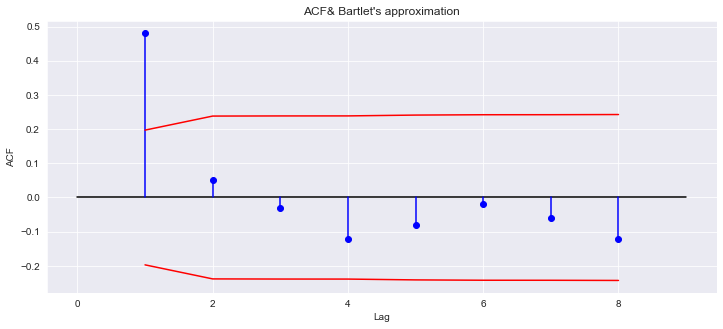

In [47]:
residual_acf = [0.48 ,0.05 ,-0.03 ,-0.12 ,-0.08 ,-0.02 ,-0.06 ,-0.12]
Analysis.Ljung_Box(residual_acf, 2,99,8,0.05)
B = Analysis.Bartlets_apprx(residual_acf,nsize=99,k=8)
B

In [20]:
1.2**2

1.44

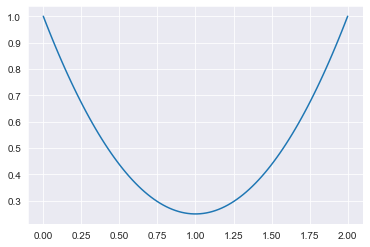

In [21]:
def f(x):
    return 1-1.5*x+0.75*x**2
x =np.linspace(0,2,100)
plt.plot(x,f(x))

## Iuput data

In [22]:
class ARMAdata:
    def __init__(self,tsd):
        """
        """
        self.data = tsd

    def acf(self,lag):
        tsd = self.data
        n = len(tsd)
        gamma = []
        gamma_0 = np.var(tsd)
        for k in range(lag):
            zk = tsd[k+1:]
            zt = tsd[:n-k-1]
            gamma_k =  sum([(zk[i]-np.mean(tsd))*(zt[i]-np.mean(tsd)) for i in range(n-k-1)])/gamma_0
            gamma.append(gamma_k)

        return gamma

## Ts_sample
Given sample somes calculations

In [40]:
class ts_sample:
    def __init__(self,data):
        self.name='Time Series from sampling data'
        self.data =data 
        self.acf = self.acf()[1:]
        self.pacf = self.pacf_kk(self.acf)
    
    def plot(self):
        data = self.data
        plt.figure(figsize = (14,6))
        plt.plot(data, color = 'black',marker=".")
        plt.show()
            
    def acf(self):
        """
        sample autocorrelation function
        """
        tsdata = self.data
        n = len(tsdata)
        k = n if n <20 else 20
        acf_list = []

        varz = sum((tsdata-np.mean(tsdata))**2)
        barz = np.mean(tsdata)
        for i in range(k):
            zt = tsdata[0:n-i]
            zt_k = tsdata[i:]
            rk = sum((zt-barz)*(zt_k-barz))/varz
            acf_list.append(rk)
        #print(acf_list)
        return acf_list

    def pacfk(self,acf_list,k):
        """
        use acf to culculate partial autocorrelation Yule-Walker equations
        """
        n = len(acf_list)
        rho_v = np.array(acf_list)
        rho_m = np.ones((n,n))
        for i in range(n):
            for j in range(n):
                if i ==j : rho_m[i,j]=1
                elif i < j: rho_m[i,j] = acf_list[j-i-1]
                elif i >j : rho_m[i,j] = acf_list[i-j-1]
        #print(rho_m,rho_v)
        #print(np.linalg.inv(rho_m[0:k,0:k]))
        pacf_v = np.dot(np.linalg.inv(rho_m[0:k,0:k]),rho_v[:k].reshape(-1,1))
        #print(pacf_v)
        return pacf_v
    
    def pacf_kk(self,acf_list):
        pacf_kk_list = []
        for i in range(1,len(acf_list)+1):
            pacf_list = self.pacfk(acf_list,i)
            pacf_kk_list.append(pacf_list[-1])
        return pacf_kk_list
    
#    def plot_acf(self):
#        Analysis.Bartlets_apprx(self.acf[:20],len(self.data),'acf')
#    def plot_pacf(self):
#        Analysis.Bartlets_apprx(self.pacf[:20],len(self.data),'pacf')

In [24]:
ts = ARMAseries(phi=[0.6],theta=[-0.3])
z,a = ts.generate_serise(100,sigma2=1)
a = ts_sample(z)

In [25]:
a = ts_sample([20,22,28,24,24,27,27,24,22,19,21,18,20,22,23,22])
a.acf
a.pacf

[array([0.53086074]),
 array([-0.09485489]),
 array([0.1141851]),
 array([-0.22490645]),
 array([-0.34158938]),
 array([-0.14626247]),
 array([-0.06942156]),
 array([0.26852985]),
 array([-0.21713988]),
 array([0.0008724]),
 array([-0.11464999]),
 array([-0.15921159]),
 array([-0.00799951]),
 array([-0.06717715]),
 array([0.07549883])]

In [26]:
np.mean([20,22,28,24,24,27,27,24,22,19,21,18,20,22,23,22])

22.6875

In [27]:
(0.6**2-0.5)/(0.6**2-1)

0.21875000000000003

In [28]:
(1+2.2**2+1.7**2+0.5**2)

8.98

In [29]:
a.pacf_kk([1.2727,0.8099])

[array([1.2727]), array([1.30672902])]

In [37]:
from DatabaseManagement import *
df = get_data("AAPL")

In [80]:
sequence = df["Adj_Close"].dif().values[-65:]
ts_squence = ts_sample(sequence)

SyntaxError: invalid syntax (<ipython-input-80-f81e998c01b3>, line 1)

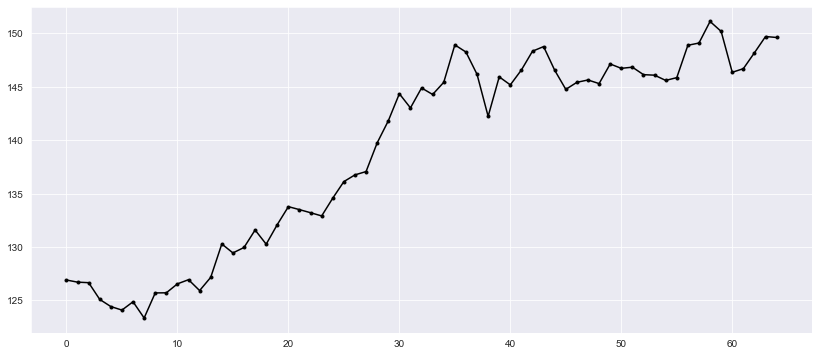

In [77]:
ts_squence.plot()

[(-0.4496, 0.4496),
 (-0.7582, 0.7582),
 (-0.9571, 0.9571),
 (-1.1092, 1.1092),
 (-1.2329, 1.2329),
 (-1.3364, 1.3364),
 (-1.4221, 1.4221),
 (-1.4928, 1.4928),
 (-1.5497, 1.5497),
 (-1.5961, 1.5961),
 (-1.6344, 1.6344),
 (-1.6659, 1.6659),
 (-1.6913, 1.6913),
 (-1.7114, 1.7114),
 (-1.7271, 1.7271),
 (-1.7392, 1.7392),
 (-1.7477, 1.7477),
 (-1.7533, 1.7533),
 (-1.7568, 1.7568),
 (-1.7586, 1.7586)]

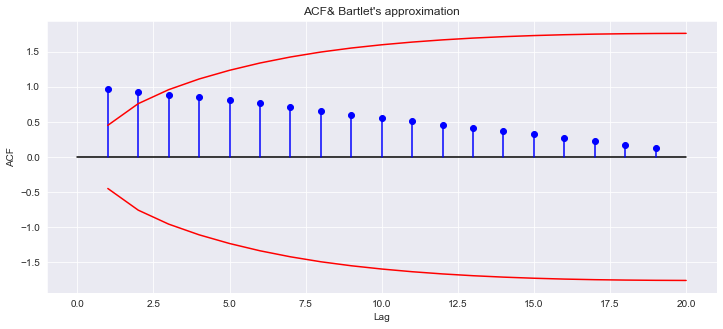

In [78]:
Analysis.Bartlets_apprx(ts_squence.acf)

d:\python37\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
d:\python37\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
d:\python37\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

[(-0.4496, 0.4496),
 (array([-0.7582]), array([0.7582])),
 (array([-0.7585]), array([0.7585])),
 (array([-0.7588]), array([0.7588])),
 (array([-0.7588]), array([0.7588])),
 (array([-0.7589]), array([0.7589])),
 (array([-0.765]), array([0.765])),
 (array([-0.7672]), array([0.7672])),
 (array([-0.773]), array([0.773])),
 (array([-0.7732]), array([0.7732])),
 (array([-0.7733]), array([0.7733])),
 (array([-0.7734]), array([0.7734])),
 (array([-0.7735]), array([0.7735])),
 (array([-0.7735]), array([0.7735])),
 (array([-0.7735]), array([0.7735])),
 (array([-0.7735]), array([0.7735])),
 (array([-0.7825]), array([0.7825])),
 (array([-0.7828]), array([0.7828])),
 (array([-0.7829]), array([0.7829])),
 (array([-0.7829]), array([0.7829]))]

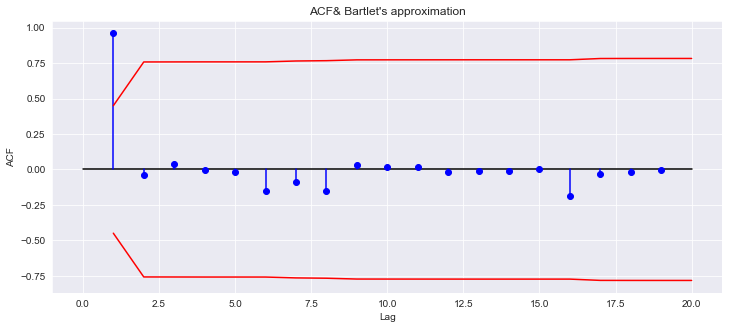

In [79]:
Analysis.Bartlets_apprx(ts_squence.pacf)

In [72]:
ts_squence.pacf

[array([0.99622806]),
 array([0.02556497]),
 array([0.00159282]),
 array([0.0159515]),
 array([-0.00165427]),
 array([-0.0312456]),
 array([0.00040702]),
 array([-0.00700698]),
 array([0.00735921]),
 array([0.00066769]),
 array([0.00321488]),
 array([-0.00467297]),
 array([-0.00315292]),
 array([0.00460668]),
 array([-0.01065036]),
 array([-0.0017616]),
 array([0.00136515]),
 array([0.00738838]),
 array([-0.03147329])]